# Bike Share Rebalancing Minimizer - Data Visualization

### OBJECTIVES:

The first objective of this portion of the project is to create several plots (mainly scatter plots) to visualize the relationships that exist between the different variables in the data set.

The second objective is to create a map that contains markers representing each Bike Share Toronto station. The size of these markers will be determined by the station's usage. The colour of the markers will be determined by the stations ride-end ratio. As stated in previous sections of this project, ride-end ratio is defined as:

$$
\frac{\text{number of rides ended at station}}{\text{number of rides ended at station + number of rides started at station}}\
$$

### DATA SOURCES:
   * See data aggregation file: [data.ipynb](https://github.com/stephensavoia/rebalancing_minimizer/blob/main/data.ipynb)

### STEPS:

   * [1. Import Data](#1)
   * [2. Make Plots](#2)
   * [3. Make Maps](#3)

### 1. IMPORT DATA <a class="anchor" id="1"></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcols
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

In [2]:
# Import data
data = pd.read_parquet('station_data.parquet', engine='pyarrow')

# Drop unneeded columns
data = data.drop(['start_count', 'end_count'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644 entries, 0 to 643
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  644 non-null    int16  
 1   use_count   644 non-null    int32  
 2   end_ratio   644 non-null    float64
 3   lat         644 non-null    float64
 4   lon         644 non-null    float64
 5   elevation   644 non-null    float64
dtypes: float64(4), int16(1), int32(1)
memory usage: 28.9 KB


### 2. MAKE PLOTS <a class="anchor" id="2"></a>

In [3]:
# Set colours, for future use in all graphs (colour palette taken from Bike Share Toronto website)
c_1_hex = "#006448"
c_2_hex = "#ea7023"
c_3_hex = "#01ae42"
c_1_dec_alpha8 = (0,0.4,0.28,0.8)
c_1_dec_alpha2 = (0,0.4,0.28,0.2)

# Set default seaborn color palette
sns.set_palette(sns.color_palette(["#006448","#ea7023","#01ae42"]))

# Create colour maps that match the theme of the project
# Use np.repeat to create as steeper color gradient, where necessary
cmap1 = pltcols.LinearSegmentedColormap.from_list(
    "", np.repeat(c_1_hex, 6).tolist() + ['white'] + np.repeat(c_2_hex, 6).tolist())
cmap2 = pltcols.LinearSegmentedColormap.from_list("", [c_2_hex, 'white'] + np.repeat(c_1_hex, 3).tolist())
cmap3 = pltcols.LinearSegmentedColormap.from_list(
    "", np.repeat('white', 8).tolist() + [c_3_hex] + np.repeat('white', 8).tolist())
cmap4 = pltcols.LinearSegmentedColormap.from_list(
    "", np.repeat('white', 3).tolist() + [c_3_hex] + np.repeat('white', 7).tolist())

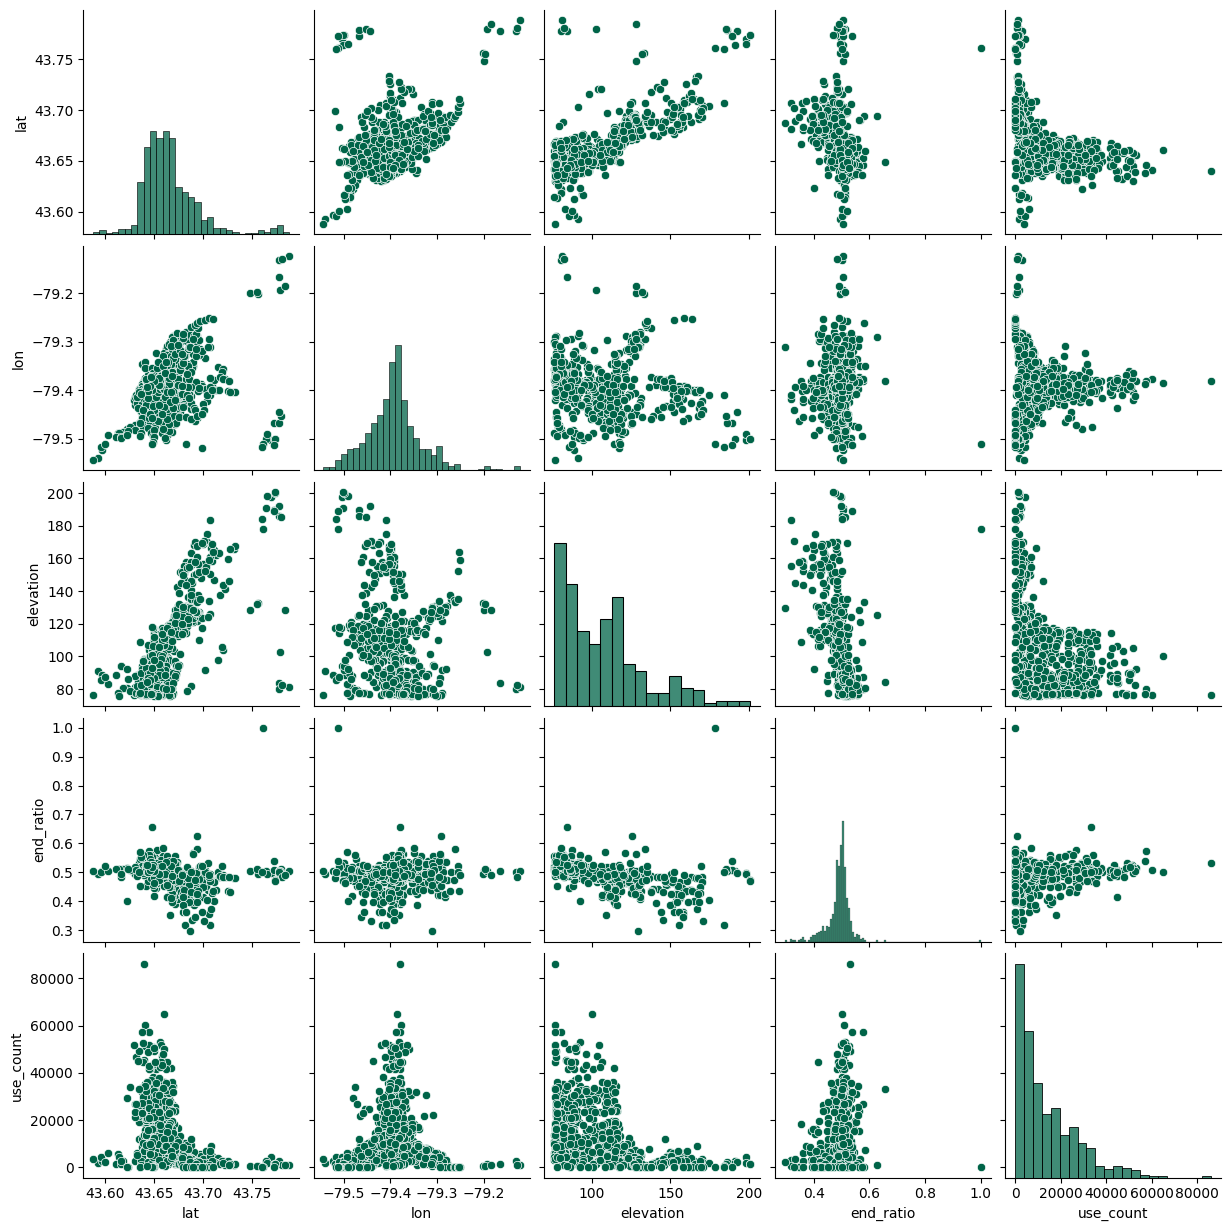

In [4]:
# Display pairplot of data
sns.pairplot(data[['lat', 'lon', 'elevation', 'end_ratio', 'use_count']])

Text(145, 0.88, 'Station 7756')

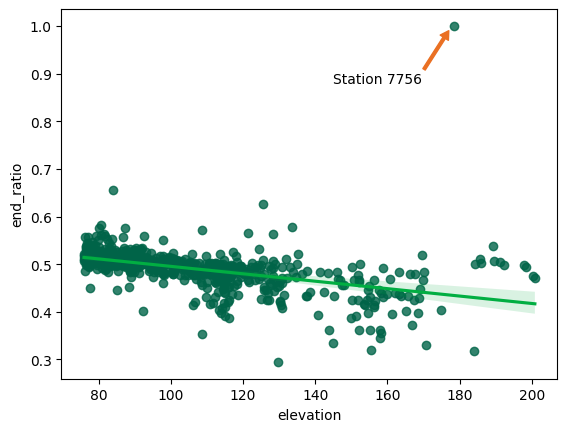

In [5]:
# Looking at the "end_ratio" row of the pairplot above, it can be seen that one data point is very far from the rest. This
# data point is Station 7756 (see data.ipynb, Section 2), which has only "end_count" data (1 ride) and no "start_count"
# data. Since the statistic "end_ratio" is not weighted in any way by the station's use, Station 7756 would have an effect
# on a linear regression of "end_ratio" equal to that of any other station, even though its "end_ratio" is derived from
# only 1 ride out of 4,230,582 rides in the data set. For this reason, Station 7756 will be removed from the data frame.

# Plot regplot
sns.regplot(x="elevation", y="end_ratio", data=data,
                 line_kws={"color": "#01ae42"})
plt.annotate('Station 7756', xy=(177,0.99), xytext=(145, 0.88),
            arrowprops=dict(facecolor=c_2_hex, edgecolor=c_2_hex, width=2, headwidth=7, headlength=6))

In [6]:
# Drop Station 7756
data = data.drop(data[data['station_id'] == 7756].index).reset_index(drop=True)

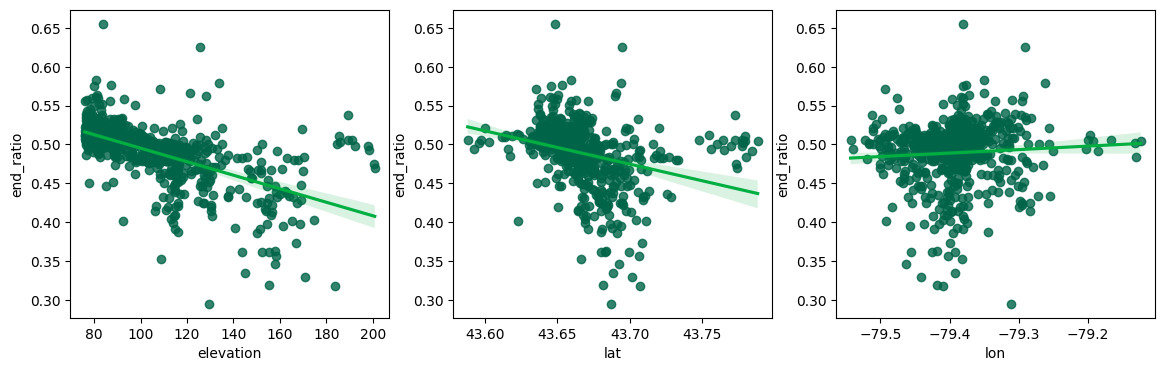

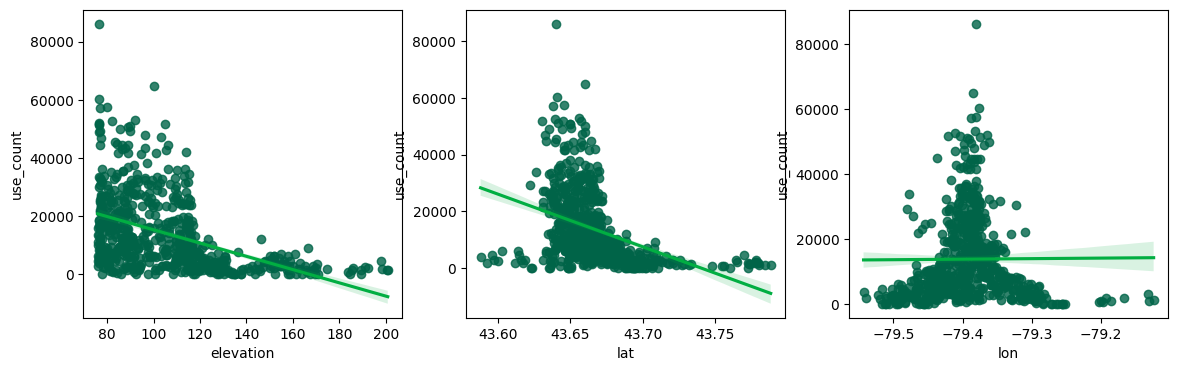

In [7]:
# Make lists of x and y variables to iterate through
ys = ['end_ratio', 'use_count']
xs = ['elevation', 'lat', 'lon']

# For each y variable, create a figure and then make 3 subplots, 1 for each of the x variables
for y_counter, y_var in enumerate(ys):
    fig, axs = plt.subplots(ncols=len(xs), figsize=(14,4))
    for x_counter, x_var in enumerate(xs):
        sns.regplot(x=x_var, y=y_var, data=data, ax=axs[x_counter], line_kws={"color": "#01ae42"})

It can be seen from the plots above that elevation has a relatively strong correlation with a station's end-ratio. This means that elevation will be an important feature to use when creating a linear regression model that predicts a station's end-ratio.

Another finding from the plots above is that elevation seems to correlate with latitude. This is to be expected, as Toronto is built on land that slopes downwards, towards the south.

Lastly, it should be noted that the last few plots (use_count vs. elevation, lat, and lon) don't show any meaningful linear relationships. Rather, they show that use_count is centred around downtown Toronto.

### 3. MAKE MAPS <a class="anchor" id="3"></a>

Text(0.455, -0.045, "Plot size indicates a station's usage, with larger plots meaning more usage.\nPlot color indicates the station's ride-end ratio (ride-end usage / total usage).")

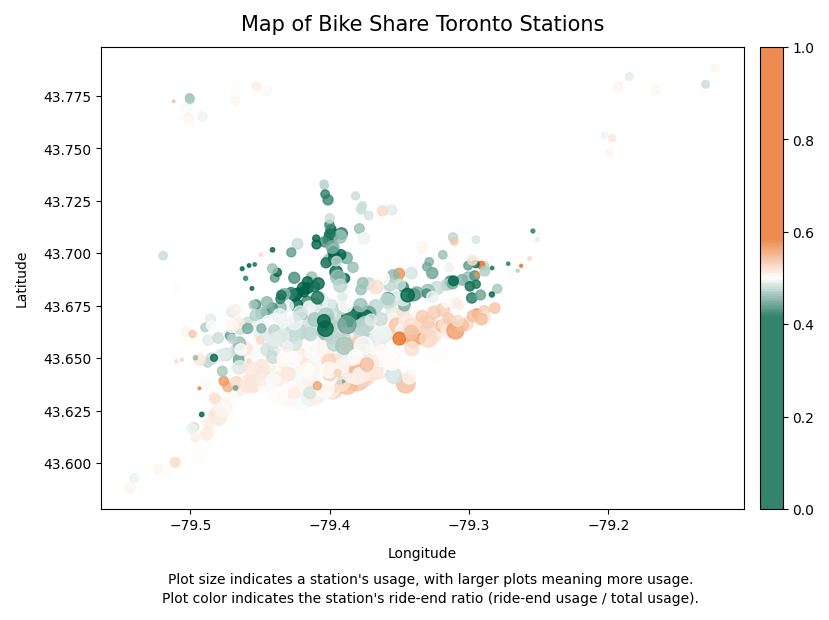

In [8]:
# Make a map that contains markers representing each Bike Share Toronto station. The size of these markers will be
# determined by the station's usage. The colour of the markers will be determined by the stations ride-end ratio.

# (Ideally, this would be created using Mapbox, but I am too cheap to give them my credit card information to get an
# API key. You will have to imagine that there is an interactive map of Toronto behind this data, similar to this:
# https://plotly.com/python/scattermapbox/ )

# Set plot style parameters
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['savefig.pad_inches'] = 0.15
plt.rcParams['figure.figsize'] = 7, 5

# Make the plot
plt.figure(figsize=(10,6))
plt.scatter(x=data['lon'], y=data['lat'], s=np.sqrt(data['use_count']), c=data['end_ratio'], vmin=0, vmax=1,
            cmap=cmap1, alpha=0.8)
plt.colorbar(pad=0.02)
plt.title('Map of Bike Share Toronto Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.figtext(0.455, -0.045,
            "Plot size indicates a station's usage, with larger plots meaning more usage.\nPlot color indicates the station's ride-end ratio (ride-end usage / total usage).",
            ha="center", fontsize=10, linespacing=1.4)

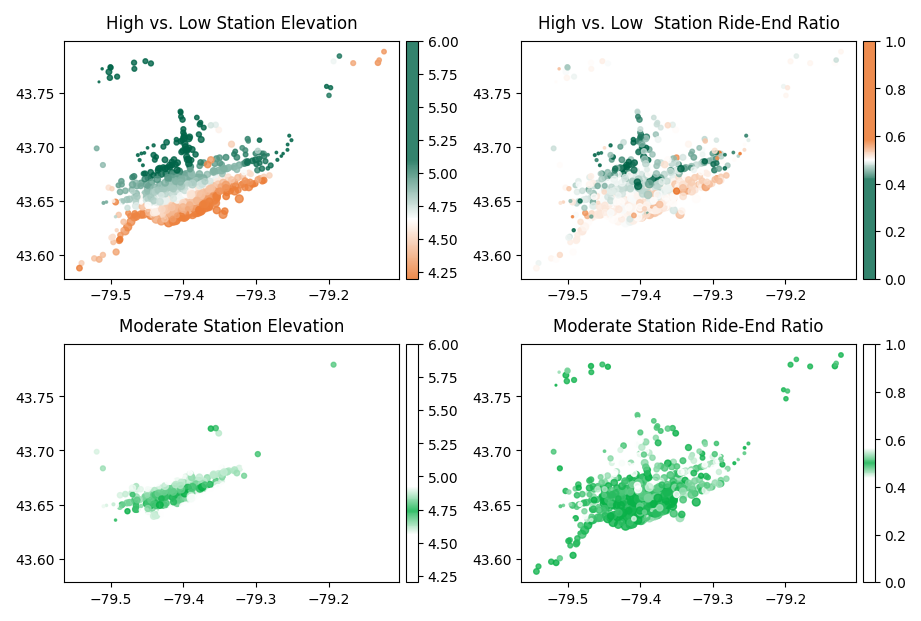

In [9]:
# Set plot style parameters
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.titlepad'] = 9
plt.rcParams['axes.labelpad'] = 5

# Initiate figure
fig_b, axs_b = plt.subplots(nrows=2, ncols=2, figsize=(9,6), layout="constrained",
                            gridspec_kw={'wspace': 0.03, 'hspace': 0.05})

# Create list of subplot info (in a manner that mimmicks "axs_b")
subplots_info = [[
    ['High vs. Low Station Elevation', np.cbrt(data['elevation']), cmap2, 4.2, 6],
    ['High vs. Low  Station Ride-End Ratio', data['end_ratio'], cmap1, 0, 1]
    ],
[
    ['Moderate Station Elevation', np.cbrt(data['elevation']), cmap4, 4.2, 6],
    ['Moderate Station Ride-End Ratio', data['end_ratio'], cmap3, 0, 1],
]]

# Make each subplot, using the information in "subplots_info"
for col in range(2):
    for row in range(2):
        temp_ax = axs_b[row, col]
        temp_subplot = temp_ax.scatter(x=data['lon'], y=data['lat'], s=np.cbrt(data['use_count']),
                                       c=subplots_info[row][col][1],
            cmap=subplots_info[row][col][2], alpha=0.8, vmin=subplots_info[row][col][3], vmax=subplots_info[row][col][4])
        temp_ax.set_title(subplots_info[row][col][0])
        fig_b.colorbar(temp_subplot, ax=temp_ax, pad=0.02)

Looking at the 2 X 2 grid above, it can be seen that the maps depicting highest vs. lowest station elevation and ride-ratio (top row) overlap quite nicely. Looking at the second row, it can be seen that stations with ride-end ratios of ~0.5 can be found all over downtown Toronto—regardless of elevation.

With this in mind, it's likely that a linear regression model: (a) could accurately predict what *type* of lopsided ride-end ratio a proposed station could potentially have, based on that station's latitude but, (b) would most likely not be able to predict *whether or not* the proposed station would have a lopsided ride-end ratio, or one around ~0.5.